In [12]:
import torch
import torch.nn as nn
import numpy as np
import cvxpy as cp
from cvxpylayers.torch import CvxpyLayer

# plotting
import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects

# neuromancer
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.constraint import variable
from neuromancer.dataset import DictDataset
from neuromancer.loss import PenaltyLoss
from neuromancer.modules import blocks
from neuromancer.system import Node

# Problem Formulation

We solve the following MIQP problem:
$$
\begin{align}
&\text{minimize } && \mathbf{x}^T \mathbf{x} + \mathbf{p}^T \mathbf{x} \\
&\text{subject to} && \mathbf{x} \le \mathbf{b}, \\
& && \mathbf{1}^T \mathbf{x} \le a, \\
& && \mathbf{x} \le M \mathbf{y}, \\
& && \mathbf{1}^T \mathbf{y} \le 1,
\end{align}
$$
where $\mathbf{x} \in \mathbb{R}^2$ and $\mathbf{y} \in \{0,1\}^2$ are the continuous and binary optimization variables. The parameters include $\mathbf{p}$, $\mathbf{b}$, and $a$.


# Data generation

In [13]:
nx = 2 #  number of continuous decision variables
ny = 2 #  number of integer decision variables
data_seed = 18 # random seed used for simulated data
np.random.seed(data_seed)
torch.manual_seed(data_seed)

p_low, p_high = -30.0, 5.0 # linear term in the objective x.T*x + p.T*x
b_low, b_high = 5.0, 25.0 # RHS of the constraint x <= b
a_low, a_high = 10.0, 30.0 # RHS of the constraint 1.T*x <= a

ntrain = 5000  # number of datapoints: increase sample density for more robust results
ntest = 500 
samples_train = {"p": torch.FloatTensor(ntrain, nx).uniform_(p_low, p_high),
                "b": torch.FloatTensor(ntrain, nx).uniform_(b_low, b_high),
                "a": torch.FloatTensor(ntrain, 1).uniform_(a_low, a_high),
                }
samples_dev = {"p": torch.FloatTensor(ntrain, nx).uniform_(p_low, p_high),
                "b": torch.FloatTensor(ntrain, nx).uniform_(b_low, b_high),
                "a": torch.FloatTensor(ntrain, 1).uniform_(a_low, a_high),
                }
samples_test = {"p": torch.FloatTensor(ntest, nx).uniform_(p_low, p_high),
                "b": torch.FloatTensor(ntest, nx).uniform_(b_low, b_high),
                "a": torch.FloatTensor(ntest, 1).uniform_(a_low, a_high),
                }
# create named dictionary datasets
train_data = DictDataset(samples_train, name='train')
dev_data = DictDataset(samples_dev, name='dev')
test_data = DictDataset(samples_test, name='test')
# create torch dataloaders for the Trainer
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, num_workers=0,
                                           collate_fn=train_data.collate_fn, shuffle=True)
dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=32, num_workers=0,
                                         collate_fn=dev_data.collate_fn, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, num_workers=0,
                                         collate_fn=test_data.collate_fn, shuffle=True)


# MLP block with Straight-Through Estimator (STE) for rounding

In [14]:
from neuromancer.modules.blocks import Block, MLP
import neuromancer.slim as slim
from neuromancer.modules.activations import soft_exp, SoftExponential, SmoothedReLU

# STE_Round operator; see https://arxiv.org/pdf/1308.3432
class STE_Round(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        return torch.round(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output

class MLPWithSTE(Block):
    """
    Multi-Layer Perceptron consistent with blocks interface
    Using STE_Round operator defined above for the classifier
    """
    def __init__(
        self,
        insize,
        outsize,
        bias=True,
        linear_map=slim.Linear,
        nonlin=SoftExponential,
        hsizes=[64],
        linargs=dict(),
    ):
        """
        :param insize: (int) dimensionality of input
        :param outsize: (int) dimensionality of output
        :param bias: (bool) Whether to use bias
        :param linear_map: (class) Linear map class from neuromancer.slim.linear
        :param nonlin: (callable) Elementwise nonlinearity which takes as input torch.Tensor and outputs torch.Tensor of same shape
        :param hsizes: (list of ints) List of hidden layer sizes
        :param linargs: (dict) Arguments for instantiating linear layer
        :param dropout: (float) Dropout probability
        """
        super().__init__()
        self.in_features, self.out_features = insize, outsize
        self.nhidden = len(hsizes)
        sizes = [insize] + hsizes + [outsize]
        self.nonlin = nn.ModuleList(
            [nonlin() for k in range(self.nhidden)] + [nn.Identity()]
        )
        self.linear = nn.ModuleList(
            [
                linear_map(sizes[k], sizes[k + 1], bias=bias, **linargs)
                for k in range(self.nhidden + 1)
            ]
        )

    def reg_error(self):
        return sum([k.reg_error() for k in self.linear if hasattr(k, "reg_error")])

    def block_eval(self, x):
        """
        :param x: (torch.Tensor, shape=[batchsize, insize])
        :return: (torch.Tensor, shape=[batchsize, outsize])
        """
        for lin, nlin in zip(self.linear, self.nonlin):
            x = nlin(lin(x))
        probs = torch.sigmoid(x)
        hard_output = STE_Round.apply(probs)
        return hard_output

# Slacked QP Formulation

We solve the following MIQP problem:
$$
\begin{align}
&\text{minimize } && \mathbf{x}^\top \mathbf{x} + \mathbf{p}^\top \mathbf{x} + \mathbf{s}^\top \mathbf{s} \\
&\text{subject to} && \mathbf{x} \le \mathbf{b}, \\
& && \mathbf{1}^\top \mathbf{x} \le a, \\
& && \mathbf{x} \le M \mathbf{y} + \mathbf{s}, \\
& && \mathbf{1}^\top \mathbf{y} \le 1, \\
& && \mathbf{s} \ge 0,
\end{align}
$$
where $\mathbf{x} \in \mathbb{R}^2$ and $\mathbf{y} \in \{0,1\}^2$ are the continuous and binary optimization variables. The parameters include $\mathbf{p}$, $\mathbf{b}$, and $a$.

In [15]:
def QP_Layer(nx, ny, penalty="l1", rho1=1.0, **kwargs):
    # Define CVXPY variables and parameters
    x = cp.Variable((nx,))  # continuous decision variables
    y = cp.Parameter((ny,))  # integer decision variables

    p = cp.Parameter((nx,))  # linear term in the objective
    b = cp.Parameter((nx,))  # RHS of the constraint x <= b
    a = cp.Parameter((1,))   # RHS of the constraint 1.T*x <= a
    s = cp.Variable((nx,), nonneg=True)  # slack variables

    # M = 1e3 * np.eye(nx)  # big-M matrix

    # Define the QP problem
    objective = cp.Minimize(cp.quad_form(x, np.eye(nx)) + p.T @ x + cp.quad_form(s, np.eye(nx)))
    constraints = [
        x <= b,
        sum(x) <= a,
        x <= 1e3 * y + s,
        s >= 0,
    ]
    problem = cp.Problem(objective, constraints)

    # Create CVXPY layer
    cvxpylayer = CvxpyLayer(problem, parameters=[p, b, a, y], variables=[x, s])
    return cvxpylayer

In [16]:
@torch.no_grad()
def _check_shapes(p, b, a, y):
    """    Quick assertion helper. Accepts batched tensors:
    - p: (B,n), b: (B,n), a: (B,1) or (B,), M: (B,n,ny), y: (B,ny)
    """
    B = p.shape[0]
    n = p.shape[1]
    ny = y.shape[1]
    assert b.shape == (B, n)
    assert y.shape == (B, ny)
    assert a.shape in [(B,), (B, 1)]
    return B, n, ny

In [17]:
def solve_qp_with_slacks(layer: CvxpyLayer, p, b, a, y):
    """
    Run the CVXPYLayer in batch. All inputs are torch tensors.
    Returns x, s (each torch tensor with grad).
    """
    _, _, _ = _check_shapes(p, b, a, y)
    if a.ndim == 1:
        a = a.unsqueeze(-1)

    # Device management
    device = p.device
    layer = layer.to(device)
    p = p.to(device)
    b = b.to(device)
    a = a.to(device)
    y = y.to(device)

    x_opt, s_opt = layer(p, b, a, y)
    return x_opt, s_opt

In [18]:
from concurrent.futures import ProcessPoolExecutor, as_completed
import multiprocessing as mp
import sys
import os

def _solve_single_miqp(args):
    """Helper function to solve a single MIQP problem."""
    # Redirect stdout and stderr to devnull at the start of each process
    sys.stdout = open(os.devnull, 'w')
    sys.stderr = open(os.devnull, 'w')
    """Helper function to solve a single MIQP problem."""
    i, p_i, b_i, a_i, nx, ny = args
    
    # Variables
    x = cp.Variable(nx)
    y = cp.Variable(ny, boolean=True)
    
    # Objective and constraints
    objective = cp.Minimize(cp.sum_squares(x) + p_i @ x)
    constraints = [
        x <= b_i,
        cp.sum(x) <= a_i,
        cp.sum(y) <= 1,
        x <= 1e3 * y
    ]
    
    # Problem definition
    prob = cp.Problem(objective, constraints)
    
    try:
        prob.solve(solver=cp.GUROBI, verbose=False, OutputFlag=0)
        
        if x.value is not None and y.value is not None:
            return i, x.value, y.value
        else:
            return i, np.zeros(nx), np.zeros(ny)
    except Exception as e:
        print(f"Error solving sample {i}: {e}")
        return i, np.zeros(nx), np.zeros(ny)

@torch.no_grad()
def GUROBI_solve_parallel(p: torch.Tensor, b: torch.Tensor, a: torch.Tensor, max_workers=None):
    """
    Solve MIQP for each sample in the batch using parallel processing.
    """
    device = p.device
    p_np = p.detach().cpu().numpy()
    b_np = b.detach().cpu().numpy()
    a_np = a.detach().cpu().numpy()
    
    if a_np.ndim == 2:
        a_np = a_np.squeeze(-1)
    
    B = p_np.shape[0]
    
    # Prepare arguments for parallel execution
    args_list = [(i, p_np[i], b_np[i], a_np[i], nx, ny) for i in range(B)]
    
    # Preallocate result arrays
    x_results = np.zeros((B, nx))
    y_results = np.zeros((B, ny))
    
    # Use ProcessPoolExecutor for parallel solving
    if max_workers is None:
        max_workers = min(B, mp.cpu_count())
    
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(_solve_single_miqp, args): args[0] for args in args_list}
        
        for future in as_completed(futures):
            i, x_sol, y_sol = future.result()
            x_results[i] = x_sol
            y_results[i] = y_sol
    
    return torch.tensor(x_results).float().to(device), torch.tensor(y_results).float().to(device)

##### Batch Solve Demo

In [19]:
for batch in train_loader:
    p_batch = batch['p']
    b_batch = batch['b']
    a_batch = batch['a']
    B = p_batch.shape[0]
    M_batch = torch.ones(B, nx, ny) * 50.0  # Big-M matrix
    
    device = p_batch.device  # use your current device
    B, n = p_batch.shape
    ny = M_batch.shape[-1]

    # 4.1 Build the layer once
    cvx_layer = QP_Layer(nx=n, ny=ny, penalty="l2", rho1=0.1)

    int_func = MLPWithSTE(insize=2*nx+1, outsize=ny,
                bias=True,
                linear_map=torch.nn.Linear,
                nonlin=nn.ReLU,
                hsizes=[128] * 4)
    int_sol_map = Node(int_func, ['p', 'b', 'a'], ['y'], name='int_map')

    # 4.2 Get y from your classifier Node
    state = {'p': p_batch, 'b': b_batch, 'a': a_batch}
    state = int_sol_map(state)          # Neuromancer Node is callable on dict
    y_pred_hard = state['y'].float()    # (B, ny), hard {0,1} via STE forward

    # 4.3 Solve the convex subproblem given y
    x_opt, s_opt = solve_qp_with_slacks(
        cvx_layer, p_batch, b_batch, a_batch, y_pred_hard
    )

    # 4.4 Solve with GUROBI for comparison
    x_solver, y_solver = GUROBI_solve_parallel(p_batch, b_batch, a_batch)

    obj_val = torch.sum(x_opt**2, dim=1) + torch.sum(p_batch * x_opt, dim=1)  # (B,)

    print("GUROBI Solution x:", x_solver)

    print("Objective values:", obj_val)
    # print("Slack s1:", s1)
    # print("Slack s2:", s2)
    print("Slack:", s_opt)
    # print("Slack s4:", s4)
    break  # just one batch for demo

GUROBI Solution x: tensor([[14.0326, -0.0000],
        [ 0.0000,  6.8042],
        [ 0.0000, 12.2670],
        [-0.9189, -1.0631],
        [ 9.5111,  0.0000],
        [12.2572,  0.0000],
        [10.9768,  0.0000],
        [ 8.9776,  0.0000],
        [13.1954,  0.0000],
        [12.9868,  0.0000],
        [ 8.6832,  0.0000],
        [-1.9766,  8.8804],
        [ 0.0000,  5.8270],
        [ 0.0000,  7.0949],
        [ 0.0000,  8.7406],
        [ 8.4286, -1.2724],
        [ 4.7151,  0.0000],
        [ 0.5310, -1.9375],
        [-0.4964, -1.3034],
        [ 5.9783, -1.0742],
        [ 0.0000,  6.2465],
        [ 3.6084, -2.3709],
        [ 8.9081, -1.9061],
        [ 0.0000,  1.4048],
        [ 3.4197, -2.2522],
        [ 8.0320,  0.0000],
        [ 0.0000, 12.4330],
        [ 4.5204, -0.0000],
        [ 0.0000,  3.7237],
        [ 0.0000, 11.0178],
        [ 0.0000,  4.2538],
        [ 7.2182,  0.0000]])
Objective values: tensor([-240.4365, -187.8300, -150.4839,   -1.9747, -269.3962, -12

##### Self-Supervised Learning Demo

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

clf = MLPWithSTE(insize=2*nx+1, outsize=ny,
                bias=True,
                linear_map=torch.nn.Linear,
                nonlin=nn.ReLU,
                hsizes=[128] * 4)
clf.to(device)
clf.train()

optimizer = torch.optim.Adam(clf.parameters(), lr=1e-4)

cvx_layer = QP_Layer(nx=nx, ny=ny, penalty="l2",
                             rho1=0.1)
cvx_layer.to(device)

CvxpyLayer()

In [ ]:
EPOCHS = 3
log_every = 50

use_node = False  # set to True to use Neuromancer Node API for int_sol_map
global_step = 0
loss_history = []
for epoch in range(1, EPOCHS+1):
    for batch in train_loader:
        p_batch = batch['p'].to(device).float()        # (B,n)
        b_batch = batch['b'].to(device).float()        # (B,n)
        a_batch = batch['a'].to(device).float()        # (B,1)
        B = p_batch.shape[0]
        # M_batch = torch.ones(B, nx, ny) * 1e3  # Big-M matrix
        

        # ---- Predict y from [p,b,a] ----
        if use_node:
            # If you're using Neuromancer's Node API you already have:
            # state = {'p': p_batch, 'b': b_batch, 'a': a_batch}
            # state = int_sol_map(state)
            # y_pred_hard = state['y'].float()
            raise NotImplementedError("Set use_node=False or plug in your Node call here.")
        else:
            feat = torch.cat([p_batch, b_batch, a_batch], dim=-1)  # (B, 2n+1)
            # Your MLPWithSTE uses .block_eval for forward within Neuromancer.
            # When used standalone, call it like a normal module: it applies STE inside.
            y_pred_hard = clf.block_eval(feat).float()  # (B, ny), hard {0,1}

        # ---- Solve convex subproblem given y ----
        # CVXPYLayer supports autograd; keep inputs requiring grad if needed
        x_opt, s_opt = solve_qp_with_slacks(cvx_layer, p_batch, b_batch, a_batch, y_pred_hard)

        # x_solver, y_solver = GUROBI_solve_parallel(p_batch, b_batch, a_batch)

        # ---- Build losses ----
        # Primary objective (read back from solution, per-sample)
        obj_val = (x_opt**2).sum(dim=1) + (p_batch * x_opt).sum(dim=1)  # (B,)
        # obj_val_solver = (x_solver**2).sum(dim=1) + (p_batch * x_solver).sum(dim=1)  # (B,)
        # obj_loss = obj_val_solver - obj_val  # minimize difference to optimal

        # Slack penalty - should be heavily penalized
        slack_pen = (s_opt**2).sum(dim=1)  # L2 norm per sample

        # Integer constraint violation
        y_sum_penalty = torch.relu(y_pred_hard.sum(dim=1) - 1.0)  # (B,)
        # y_gt_penalty = torch.relu(torch.abs(y_solver - y_pred_hard))  # (B,)

        # Optional: Encourage binary sharpness (helps STE training)
        # y_soft = torch.sigmoid(clf.linear[-1](feat))  # Get soft outputs before STE
        # y_entropy = -(y_soft * torch.log(y_soft + 1e-8) + 
        #             (1 - y_soft) * torch.log(1 - y_soft + 1e-8)).sum(dim=1)

        # Total loss with balanced weights
        loss = (
            0.1*obj_val.mean() +                    # Main objective (no exp!)
            10.0 * slack_pen.mean() +           # Heavy slack penalty
            5.0 * y_sum_penalty.mean()        # Integer constraint penalty
            # 0.0 * y_gt_penalty.mean()          # Binary sharpness regularizer
        )
        loss_history.append(loss.item())

        # ---- Backprop ----
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(clf.parameters(), max_norm=1.0)
        optimizer.step()

        # ---- Logging ----
        if (global_step % log_every) == 0:
            print(f"[epoch {epoch} | step {global_step}] "
                  f"loss={loss.item():.4f}  obj={obj_val.mean().item():.4f}  "
                  f"slack={slack_pen.mean().item():.4f}  sum(y)={y_pred_hard.mean(dim=1).mean().item():.3f}")
        global_step += 1


[epoch 1 | step 0] loss=194.3622  obj=-97.3587  slack=29.1721  sum(y)=0.094
[epoch 1 | step 50] loss=-112.9398  obj=-117.6273  slack=0.0000  sum(y)=0.969
[epoch 1 | step 100] loss=-125.5804  obj=-130.4242  slack=0.0000  sum(y)=0.984
[epoch 1 | step 150] loss=-103.6911  obj=-108.5348  slack=0.0000  sum(y)=0.984
[epoch 2 | step 200] loss=-104.4282  obj=-109.1157  slack=0.0000  sum(y)=0.969
[epoch 2 | step 250] loss=-116.4358  obj=-120.2026  slack=0.0017  sum(y)=0.875
[epoch 2 | step 300] loss=-118.3192  obj=-123.1630  slack=0.0000  sum(y)=0.984
[epoch 3 | step 350] loss=-131.2141  obj=-134.9641  slack=0.0000  sum(y)=0.875
[epoch 3 | step 400] loss=-117.3799  obj=-122.0674  slack=0.0000  sum(y)=0.969
[epoch 3 | step 450] loss=-127.9141  obj=-132.6016  slack=0.0000  sum(y)=0.969


##### Loss Plot

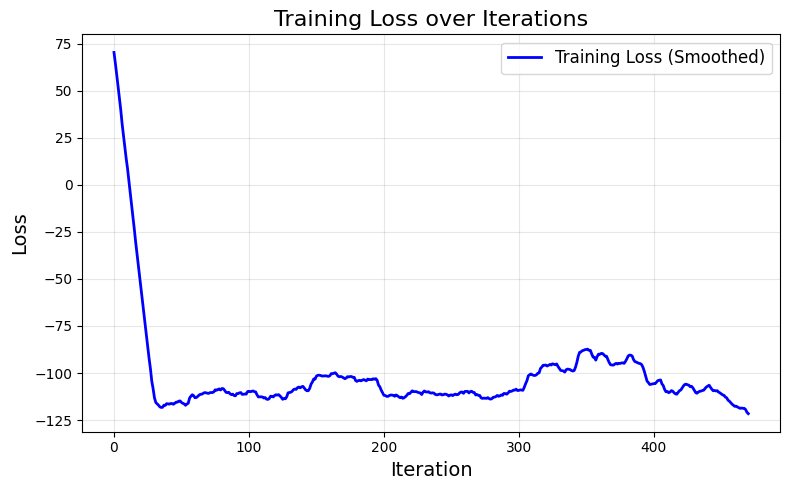

In [22]:
from matplotlib import pyplot as plt
from scipy.ndimage import uniform_filter1d
import numpy as np

##### Loss Plot with Smoothing and Downsampling
plt.figure(figsize=(8,5))

# Method 1: Simple moving average smoothing
window_size = 50  # Adjust for more/less smoothing
loss_array = np.array(loss_history)
smoothed_loss = uniform_filter1d(loss_array, size=window_size, mode='nearest')

# Method 2: Downsample by taking every Nth point
downsample_factor = 10
downsampled_idx = np.arange(0, len(loss_history), downsample_factor)
downsampled_loss = loss_array[downsampled_idx]

# Plot options:
# Option A: Smoothed curve
plt.plot(smoothed_loss, label='Training Loss (Smoothed)', color='blue', linewidth=2,
         path_effects=[patheffects.withStroke(linewidth=4, foreground="w")])

# Option B: Both raw and smoothed
# plt.plot(loss_history, label='Raw Loss', color='lightblue', alpha=0.3, linewidth=1)
# plt.plot(smoothed_loss, label='Smoothed Loss', color='blue', linewidth=2)

# Option C: Downsampled points
# plt.scatter(downsampled_idx, downsampled_loss, label='Downsampled Loss', 
#            color='blue', s=10, alpha=0.6)

plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training Loss over Iterations', fontsize=16)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

##### Gurobi Check

In [23]:
def QP_Layer_without_slacks(nx, ny, **kwargs):
    # Define CVXPY variables and parameters
    x = cp.Variable((nx,))  # continuous decision variables
    y = cp.Parameter((ny,))  # integer decision variables

    p = cp.Parameter((nx,))  # linear term in the objective
    b = cp.Parameter((nx,))  # RHS of the constraint x <= b
    a = cp.Parameter((1,))   # RHS of the constraint 1.T*x <= a

    # M = 1e3 * np.eye(nx)  # big-M matrix

    # Define the QP problem
    objective = cp.Minimize(cp.quad_form((p / 2  + x), np.eye(nx)))
    constraints = [
        x <= b,
        sum(x) <= a,
        x <= 1e3 * y,
    ]
    problem = cp.Problem(objective, constraints)

    # Create CVXPY layer
    cvxpylayer = CvxpyLayer(problem, parameters=[p, b, a, y], variables=[x])
    return cvxpylayer

def solve_qp_without_slacks(layer: CvxpyLayer, p, b, a, y):
    """
    Run the CVXPYLayer in batch. All inputs are torch tensors.
    Returns x (torch tensor with grad).
    """
    _, _, _ = _check_shapes(p, b, a, y)
    if a.ndim == 1:
        a = a.unsqueeze(-1)

    # Device management
    device = p.device
    layer = layer.to(device)
    p = p.to(device)
    b = b.to(device)
    a = a.to(device)
    y = y.to(device)

    x_opt = layer(p, b, a, y)
    return x_opt

In [24]:
# Test case
# Solution from Neuromancer
a = [15.0]; b = [12.0, 15.0]; p = [-20.0, -12.0]
datapoint = {'a': torch.tensor([a]), 'b': torch.tensor([b]), 'p': torch.tensor([p]),
             'name': 'test'}
# model_out = problem(datapoint)
# x_nm = model_out['test_' + "x_cvx"][0].detach().numpy()
# y_nm = model_out['test_' + "y"][0].detach().numpy()
# print(x_nm, y_nm)

bigM = 1e3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

clf.eval()
qp_layer = QP_Layer_without_slacks(nx=nx, ny=ny)
# clf.no_grad()

# M_mat = torch.ones(1, nx, ny) * bigM  # Big-M matrix
y_nm = clf.block_eval(torch.cat([datapoint['p'].float(), datapoint['b'].float(), datapoint['a'].float()], dim=-1).to(device))
x_nm, = solve_qp_without_slacks(
    qp_layer, datapoint['p'].float().to(device), datapoint['b'].float().to(device), datapoint['a'].float().to(device),
    torch.tensor(y_nm).float().to(device)
)
y_nm = y_nm.detach().cpu().numpy()
x_nm = x_nm.detach().cpu().numpy()
print(x_nm, y_nm)

#print objective of x_nm
x_flat = x_nm.flatten()
p_flat = datapoint['p'].cpu().numpy().flatten()
objective_value = np.sum(x_flat**2) + np.dot(p_flat, x_flat)
print("Objective value:", objective_value)


[[9.5 5.5]] [[1. 1.]]
Objective value: -135.5


/tmp/ipykernel_605807/744416635.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_nm).float().to(device)


In [25]:
# Baseline Solution of the MIQP problem with GUROBI.
def MIQP_param(p, b, a):
    # Variables
    x = cp.Variable(nx)
    y = cp.Variable(ny, boolean=True)  # declare binary variables

    # Objective and constraints
    objective = cp.Minimize(cp.sum_squares(x + np.array(p)/2))
    constraints = [
        x <= np.array(b),
        cp.sum(x) <= a,
        cp.sum(y) <= 1,
        x <= bigM * y
    ]

    # Problem definition
    prob = cp.Problem(objective, constraints)

    # Solve with Gurobi
    prob.solve(solver=cp.GUROBI, verbose=False)

    return x.value, y.value

print(MIQP_param(p, b, a))
x_opt, y_opt = MIQP_param(p, b, a)
objective_value_miqp = np.sum(x_opt**2) + np.dot(p, x_opt)
print("Objective value (MIQP):", objective_value_miqp)

Set parameter Username
Set parameter LicenseID to value 2716009
Academic license - for non-commercial use only - expires 2026-09-29
(array([10.,  0.]), array([ 1., -0.]))
Objective value (MIQP): -100.0


In [27]:
# After training, evaluate on test set
clf.eval()
test_objs_nm = []
test_objs_grb = []

with torch.no_grad():
    for batch in test_loader:
        p_batch = batch['p'].to(device).float()
        b_batch = batch['b'].to(device).float()
        a_batch = batch['a'].to(device).float()
        
        # Your solution
        feat = torch.cat([p_batch, b_batch, a_batch], dim=-1)
        y_pred = clf.block_eval(feat).float()
        x_opt, = solve_qp_without_slacks(qp_layer, p_batch, b_batch, a_batch, y_pred)
        obj_nm = (x_opt**2).sum(dim=1) + (p_batch * x_opt).sum(dim=1)
        test_objs_nm.extend(obj_nm.cpu().numpy())
        
        # Gurobi solution (for comparison)
        for i in range(p_batch.shape[0]):
            x_grb, y_grb = MIQP_param(
                p_batch[i].cpu().numpy(),
                b_batch[i].cpu().numpy(),
                a_batch[i].cpu().numpy()
            )
            if x_grb is not None:
                obj_grb = np.sum(x_grb**2) + np.sum(p_batch[i].cpu().numpy() * x_grb)
                test_objs_grb.append(obj_grb)

print(f"\nTest Set Comparison:")
print(f"CVXPY_LAYER with slacks Avg Obj: {np.mean(test_objs_nm):.4f}")
print(f"Gurobi Avg Obj: {np.mean(test_objs_grb):.4f}")
print(f"Optimality Gap: {np.mean((np.array(test_objs_nm) - np.array(test_objs_grb)) / np.abs((test_objs_grb))) * 100:.2f}%")
# for i in range(len(test_objs_nm)):
#     print(f"Test sample {i}: CVXPY_LAYER Obj = {test_objs_nm[i]:.4f}, Gurobi Obj = {test_objs_grb[i]:.4f}, Gap = {test_objs_nm[i] - test_objs_grb[i]:.4f}")
print(f"Proportion of close solutions: {np.mean(np.abs(np.array(test_objs_nm) - np.array(test_objs_grb)) < 1e-3):.4f}")


Test Set Comparison:
CVXPY_LAYER with slacks Avg Obj: -123.8820
Gurobi Avg Obj: -101.6835
Optimality Gap: -20.42%
Proportion of close solutions: 0.2760


In [ ]:
pirnt

NameError: name 'pirnt' is not defined

In [ ]:
"""
Benchmark Solution
"""
def eval_constraints(x, y, b, a):
    """
    evaluate mean constraints violations
    """
    con_1_viol = np.maximum(0, y[0] + y[1] - 1.0)
    con_2_viol = np.maximum(0, x[0] - b[0])
    con_3_viol = np.maximum(0, x[1] - b[1])
    con_4_viol = np.maximum(0, x[0] + x[1] - a)
    con_5_viol = np.maximum(0, x[0] - bigM*y[0])
    con_6_viol = np.maximum(0, x[1] - bigM*y[1])

    con_viol = con_1_viol + con_2_viol + con_3_viol + con_4_viol  + con_5_viol + con_6_viol
    
    return con_viol

def eval_objective(x, y, p):
    obj_value = np.sum((x+p/2)**2)
    return obj_value

# Solve via neuromancer
samples_test['name'] = 'test'

test_p = samples_test['p'].to(device).float()
test_b = samples_test['b'].to(device).float()
test_a = samples_test['a'].to(device).float()
B = test_p.shape[0]
M_batch = torch.ones(B, nx, ny) * bigM  # Big-M matrix

y_nm = clf.block_eval(torch.cat([test_p, test_b, test_a], dim=-1).to(device))
x_nm, s = solve_qp_with_slacks(
    cvx_layer, test_p.to(device), test_b.to(device), test_a.to(device),
    M_batch.to(device), y_nm.float().to(device)
)
# print(s_1.shape, s_2.shape, s_3.shape, s_4.shape)
# s = torch.sum(torch.abs(s_1), dim=1).reshape(-1, 1) + torch.abs(s_2) + torch.sum(torch.abs(s_3), dim=1).reshape(-1, 1) + torch.abs(s_4)
# s = s.detach().cpu().numpy()
# print(s.shape, x_nm.shape)
x_nm = x_nm.detach().cpu().numpy()#[s.flatten() < 1e-3]
y_nm = y_nm.detach().cpu().numpy()#[s.flatten() < 1e-3]

# model_out = problem(samples_test)
# x_nm = model_out['test_' + "x_cvx"].detach().numpy()
# y_nm = model_out['test_' + "y"].detach().numpy()

# Solve via solver
x_solver, y_solver = [], []
for i in range(0, ntest):
    p_test = samples_test['p'][i].detach().numpy()
    b_test = samples_test['b'][i].detach().numpy()
    a_test = samples_test['a'][i].detach().numpy()

    x_sol, y_sol = MIQP_param(p_test, b_test, a_test)
    x_solver.append(x_sol)
    y_solver.append(y_sol)

# x_grb = x_solver[x_solver.index(next(filter(lambda x: x is not None, x_solver)))]
# y_grb = y_solver[y_solver.index(next(filter(lambda x: x is not None, y_solver)))]

# x_grb = np.asarray(x_solver)
# y_grb = np.asarray(y_solver)

x_grb = np.asarray([xs for xs in x_solver if xs is not None], dtype=object)
y_grb = np.asarray([ys for ys in y_solver if ys is not None], dtype=object)

print(x_nm.shape, x_grb.shape)

TypeError: solve_qp_with_slacks() takes 5 positional arguments but 6 were given

# Using CVXPY projection layer

We utilize 2 separate MLP networks for learning x and y. The outputs of MLPs go through a CVXPY projection layer to guarantee linear constraints.


In [ ]:
# mapping problem parameters to integer decision variables
# input size should be for concatenated vector of p, b, a
# int_func = MLPWithSTE(insize=2*nx+1, outsize=ny,
#                 bias=True,
#                 linear_map=torch.nn.Linear,
#                 nonlin=nn.ReLU,
#                 hsizes=[128] * 4)
# int_sol_map = Node(int_func, ['p', 'b', 'a'], ['y'], name='int_map')

In [ ]:
# mapping problem parameters to continuous decision variables
# input size should be for concatenated vector of p, b, a
# cont_func = MLP(insize=2*nx+1, outsize=nx,
#                 bias=True,
#                 linear_map=torch.nn.Linear,
#                 nonlin=nn.ReLU,
#                 hsizes=[128] * 4)
# cont_sol_map = Node(cont_func, ['p', 'b', 'a'], ['x'], name='cont_map')

In [ ]:
# Continuous variables
# x = variable("x")
# x1 = x[:, [0]]; x2 = x[:, [1]] 
# # Binary variables
# y = variable("y")
# y1 = y[:, [0]]; y2 = y[:, [1]] 

# # problem parameters sampled in the dataset
# p1 = variable('p')[:, [0]]; p2 = variable('p')[:, [1]] # ; b3 = variable('b')[:, [2]]; b4 = variable('b')[:, [3]]
# a = variable('a')

# f = (x1+p1/2)**2 + (x2+p2/2)**2
# obj = f.minimize(weight=1.0, name='obj')

# bigM = 1e3
# Q_con = 1e3
# g1 =  y1 + y2 - 1.0 
# con_1 = Q_con * (g1 <= 0)
# con_1.name = 'c1'

# constraints = [con_1]

In [ ]:
# y_net = cp.Parameter(ny) # binary decision from neural net
# x_net = cp.Parameter(nx) # continuouis decision from neural net
# x_cvxpy = cp.Variable(ny) # cvxpy decision variable
# A_cvxpy = np.vstack([np.eye(nx), np.ones((1,nx))])
# b_cvxpy = cp.Parameter(nx)
# a_cvxpy = cp.Parameter(1)

# # projection problem formulation
# cvxpy_obj = cp.Minimize(1.0 * cp.sum_squares(x_cvxpy - x_net))
# cvxpy_cons = [x_cvxpy@A_cvxpy.T <= cp.hstack([b_cvxpy, a_cvxpy]), \
#               x_cvxpy <= bigM*y_net]
# cvxpy_prob = cp.Problem(cvxpy_obj, cvxpy_cons)
# # cvxpy layer
# cvxpy_layer = CvxpyLayer(cvxpy_prob,
#                    parameters=[b_cvxpy, a_cvxpy, y_net, x_net],
#                    variables=[x_cvxpy])
# # symbolic wrapper: sol_map(bparam, xy) -> xy
# project = Node(cvxpy_layer, ['b', 'a', 'y', 'x'], ['x_cvx'], name='qp')

In [ ]:
# corrected variable by the cvxpy layer
# x_cvx = variable("x_cvx")
# # cvxpy-supervised loss for the neural net
# residual = torch.abs(x - x_cvx)
# cvxp_loss = 1.*(residual == 0)

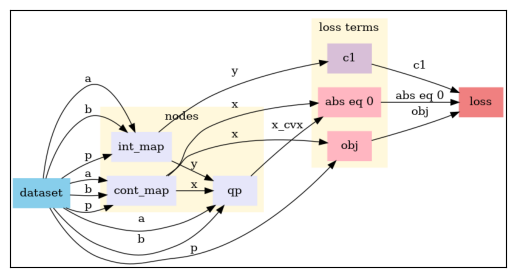

In [ ]:
# constrained optimization problem construction
# nodes = [int_sol_map, cont_sol_map, project]
# objectives = [obj, cvxp_loss]

# # create penalty method loss function
# loss = PenaltyLoss(objectives, constraints)
# # construct constrained optimization problem
# problem = Problem(nodes, loss)
# # plot computational graph
# problem.show()

In [ ]:
# lr = 1e-4      # step size for gradient descent
# epochs = 10    # number of training epochs
# warmup = 10    # number of epochs to wait before enacting early stopping policy
# patience = 10  # number of epochs with no improvement in eval metric to allow before early stopping

In [ ]:
# optimizer = torch.optim.AdamW(problem.parameters(), lr=lr)
# # define trainer
# trainer = Trainer(
#     problem,
#     train_loader,
#     dev_loader,
#     test_loader,
#     optimizer,
#     epochs=epochs,
#     patience=patience,
#     warmup=warmup,
#     train_metric="train_loss",
#     dev_metric="dev_loss",
#     test_metric="test_loss",
#     eval_metric="dev_loss",
# )

In [ ]:
# Train NLP solution map
# best_model = trainer.train()
# best_outputs = trainer.test(best_model)
# # load best model dict
# problem.load_state_dict(best_model)

/home/vietanhle/github/phdenv/lib/python3.10/site-packages/neuromancer/constraint.py:169: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([32, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.l1_loss(left, right)
/home/vietanhle/github/phdenv/lib/python3.10/site-packages/neuromancer/constraint.py:169: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([8, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.l1_loss(left, right)


epoch: 0  train_loss: 297.9198303222656
epoch: 1  train_loss: 222.70364379882812
epoch: 2  train_loss: 192.20901489257812
epoch: 3  train_loss: 209.87254333496094
epoch: 4  train_loss: 195.03250122070312
epoch: 5  train_loss: 188.31564331054688
epoch: 6  train_loss: 208.15139770507812
epoch: 7  train_loss: 209.99305725097656
epoch: 8  train_loss: 224.42984008789062
epoch: 9  train_loss: 202.1628875732422


/home/vietanhle/github/phdenv/lib/python3.10/site-packages/neuromancer/constraint.py:169: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([20, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.l1_loss(left, right)


<All keys matched successfully>

### A single test case

In [ ]:
# Test case
# Solution from Neuromancer
a = [15.0]; b = [12.0, 15.0]; p = [-20.0, -12.0]
datapoint = {'a': torch.tensor([a]), 'b': torch.tensor([b]), 'p': torch.tensor([p]),
             'name': 'test'}
model_out = problem(datapoint)
x_nm = model_out['test_' + "x_cvx"][0].detach().numpy()
y_nm = model_out['test_' + "y"][0].detach().numpy()
print(x_nm, y_nm)


[-7.5449891e-05  5.6915402e+00] [0. 1.]


/home/vietanhle/github/phdenv/lib/python3.10/site-packages/neuromancer/constraint.py:169: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.l1_loss(left, right)


In [ ]:
# Baseline Solution of the MIQP problem with GUROBI.
def MIQP_param(p, b, a):
    # Variables
    x = cp.Variable(nx)
    y = cp.Variable(ny, boolean=True)  # declare binary variables

    # Objective and constraints
    objective = cp.Minimize(cp.sum_squares((x + np.array(p)/2)))
    constraints = [
        x <= np.array(b),
        cp.sum(x) <= a,
        cp.sum(y) <= 1,
        x <= bigM * y
    ]

    # Problem definition
    prob = cp.Problem(objective, constraints)

    # Solve with Gurobi
    prob.solve(solver=cp.GUROBI, verbose=False)

    return x.value, y.value

print(MIQP_param(p, b, a))

Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-27
(array([10.,  0.]), array([1., 0.]))


# Test with dataset

It seems the trained model may produce feasible but highly sub-optimal solutions. 

In [ ]:
"""
Benchmark Solution
"""
def eval_constraints(x, y, b, a):
    """
    evaluate mean constraints violations
    """
    con_1_viol = np.maximum(0, y[0] + y[1] - 1.0)
    con_2_viol = np.maximum(0, x[0] - b[0])
    con_3_viol = np.maximum(0, x[1] - b[1])
    con_4_viol = np.maximum(0, x[0] + x[1] - a)
    con_5_viol = np.maximum(0, x[0] - bigM*y[0])
    con_6_viol = np.maximum(0, x[1] - bigM*y[1])

    con_viol = con_1_viol + con_2_viol + con_3_viol + con_4_viol  + con_5_viol + con_6_viol
    
    return con_viol

def eval_objective(x, y, p):
    obj_value = np.sum((x+p/2)**2)
    return obj_value

# Solve via neuromancer
samples_test['name'] = 'test'
model_out = problem(samples_test)
x_nm = model_out['test_' + "x_cvx"].detach().numpy()
y_nm = model_out['test_' + "y"].detach().numpy()

# Solve via solver
x_solver, y_solver = [], []
for i in range(0, ntest):
    p_test = samples_test['p'][i].detach().numpy()
    b_test = samples_test['b'][i].detach().numpy()
    a_test = samples_test['a'][i].detach().numpy()

    x_sol, y_sol = MIQP_param(p_test, b_test, a_test)
    x_solver.append(x_sol)
    y_solver.append(y_sol)

x_grb = np.asarray(x_solver)
y_grb = np.asarray(y_solver)

/home/vietanhle/github/phdenv/lib/python3.10/site-packages/neuromancer/constraint.py:169: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([500, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.l1_loss(left, right)


In [ ]:
# Evaluate neuromancer solution
nm_violation = []
grb_violation = []
nm_cost = []
grb_cost = []

for i in range(ntest):
    p_test = samples_test['p'][i].detach().numpy()
    b_test = samples_test['b'][i].detach().numpy()
    a_test = samples_test['a'][i].detach().numpy()
    nm_violation.append(eval_constraints(x_nm[i,:], y_nm[i,:], b_test, a_test))
    grb_violation.append(eval_constraints(x_grb[i,:], y_grb[i,:], b_test, a_test))

    nm_cost.append(eval_objective(x_nm[i,:], y_nm[i,:], p_test))
    grb_cost.append(eval_objective(x_grb[i,:], y_grb[i,:], p_test))

print(f'Neuromancer mean constraints violation {np.mean(nm_violation):.4f}')
print(f'Neuromancer mean cost {np.mean(nm_cost):.4f}')


print(f'GUROBI mean constraints violation {np.mean(grb_violation):.4f}')
print(f'GUROBI mean cost {np.mean(grb_cost):.4f}')



Neuromancer mean constraints violation 0.0061
Neuromancer mean cost 73.8405
GUROBI mean constraints violation 0.0000
GUROBI mean cost 32.1257


# KKT Analysis 

The new optimization problem is:
$$\begin{align} &\text{minimize } && f(\mathbf{x}, \mathbf{s}) = \mathbf{x}^\top \mathbf{x} + \mathbf{p}^\top \mathbf{x} + \mathbf{s}^\top \mathbf{s} \\ &\text{subject to} && \mathbf{x} \le \mathbf{b} \\ & && \mathbf{1}^\top \mathbf{x} \le a \\ & && \mathbf{x} - M \mathbf{\bar{y}} - \mathbf{s} \le \mathbf{0} \\ & && \mathbf{s} \ge \mathbf{0} \end{align} $$

The Lagrangian $\mathcal{L}$ (using the same multipliers) is: $$\mathcal{L} = (\mathbf{x}^\top \mathbf{x} + \mathbf{p}^\top \mathbf{x} + \mathbf{s}^\top \mathbf{s}) + \boldsymbol{\lambda}^\top (\mathbf{x} - \mathbf{b}) + \mu (\mathbf{1}^\top \mathbf{x} - a) + \boldsymbol{\nu}^\top (\mathbf{x} - M \mathbf{\bar{y}} - \mathbf{s}) + \boldsymbol{\sigma}^\top (-\mathbf{s}) $$


### 1. Stationarity

* $\nabla_{\mathbf{x}} \mathcal{L} = 2\mathbf{x} + \mathbf{p} + \boldsymbol{\lambda} + \mu \mathbf{1} + \boldsymbol{\nu} = \mathbf{0}$ 
* $\nabla_{\mathbf{s}} \mathcal{L} = 2\mathbf{s} - \boldsymbol{\nu} - \boldsymbol{\sigma} = \mathbf{0}$ 

### 2. Primal Feasibility 

* $\mathbf{x} \le \mathbf{b}$ 
* $\mathbf{1}^\top \mathbf{x} \le a$ 
* $\mathbf{x} - M \mathbf{\bar{y}} - \mathbf{s} \le \mathbf{0}$ 
* $\mathbf{s} \ge \mathbf{0}$ 

### 3. Dual Feasibility 

* $\boldsymbol{\lambda} \ge \mathbf{0}$ 
* $\mu \ge 0$ 
* $\boldsymbol{\nu} \ge \mathbf{0}$ 
* $\boldsymbol{\sigma} \ge \mathbf{0}$ 

### 4. Complementary Slackness 

* $\boldsymbol{\lambda}^\top (\mathbf{x} - \mathbf{b}) = 0$ 
* $\mu (\mathbf{1}^\top \mathbf{x} - a) = 0$ 
* $\boldsymbol{\nu}^\top (\mathbf{x} - M \mathbf{\bar{y}} - \mathbf{s}) = 0$ 
* $\boldsymbol{\sigma}^\top \mathbf{s} = 0$ 

### Analysis of the KKT System 

Analyze the conditions on $\mathbf{s}, \boldsymbol{\nu}, \boldsymbol{\sigma}$ (component-wise for $i=1, 2$): 

1. **Stationarity:** $2s_i - \nu_i - \sigma_i = 0$ 
2. **Complementary Slackness:** $\sigma_i s_i = 0$ 
3. **Feasibility:** $s_i \ge 0, \nu_i \ge 0, \sigma_i \ge 0$ We have two cases from condition (2): 

  * **Case 1: $s_i > 0$** (slack is active). 
    * Complementary slackness (2) forces $\sigma_i = 0$. 
    * Stationarity (1) becomes $2s_i - \nu_i - 0 = 0 \implies \nu_i = 2s_i$. * Since $s_i > 0$, we have $\nu_i > 0$. 
    * Since $\nu_i > 0$, the *other* complementary slackness condition $\nu_i (x_i - (M\mathbf{\bar{y}})_i - s_i) = 0$ forces its constraint to be tight: $x_i - (M\mathbf{\bar{y}})_i - s_i = 0$. 
 * **Case 2: $s_i = 0$** (slack is zero). 
    * Complementary slackness (2) $\sigma_i s_i = 0$ is satisfied for any $\sigma_i \ge 0$. 
    * Stationarity (1) becomes $2(0) - \nu_i - \sigma_i = 0 \implies \nu_i + \sigma_i = 0$. 
    * Since $\nu_i \ge 0$ and $\sigma_i \ge 0$ (Dual Feasibility), the only solution is $\nu_i = 0$ and $\sigma_i = 0$. 

**Conclusion:** In both possible cases, the dual variable $\boldsymbol{\sigma}^*$ is $\mathbf{0}$. This simplifies the KKT system significantly. The key relationships at the optimum $(\cdot)^*$ are: 
  * $\boldsymbol{\sigma}^* = \mathbf{0}$ 
  * $\boldsymbol{\nu}^* = 2\mathbf{s}^*$ The constraint $\boldsymbol{\nu}^\top (\mathbf{x} - M \mathbf{\bar{y}} - \mathbf{s}) = 0$ becomes $(2\mathbf{s})^\top (\mathbf{x} - M \mathbf{\bar{y}} - \mathbf{s}) = 0$, which is consistent with the case analysis. 

----- 



# Backward Operation Analysis 

We again use the principle that the gradient of the optimal objective $f^*$ with respect to a parameter $\theta$ is the gradient of the Lagrangian $\mathcal{L}$ with respect to $\theta$, evaluated at the optimal solution. $\nabla_{\theta} f^* = \nabla_{\theta} \mathcal{L}(\mathbf{x}^*, \mathbf{s}^*, \boldsymbol{\lambda}^*, \mu^*, \boldsymbol{\nu}^*, \boldsymbol{\sigma}^*; \theta)$ Since we found $\boldsymbol{\sigma}^* = \mathbf{0}$, we can use the simplified Lagrangian: $$\mathcal{L} = (\mathbf{x}^\top \mathbf{x} + \mathbf{p}^\top \mathbf{x} + \mathbf{s}^\top \mathbf{s}) + \boldsymbol{\lambda}^\top (\mathbf{x} - \mathbf{b}) + \mu (\mathbf{1}^\top \mathbf{x} - a) + \boldsymbol{\nu}^\top (\mathbf{x} - M \mathbf{\bar{y}} - \mathbf{s}) $$

Here are the gradients:

1. **Gradient w.r.t. $\mathbf{p}$**: $$ \nabla_{\mathbf{p}} f^* = \nabla_{\mathbf{p}} \mathcal{L} = \mathbf{x} $$At the optimum, we get: $\mathbf{x}^*$

2.  **Gradient w.r.t. $\mathbf{b}$:** $$\nabla_{\mathbf{b}} f^* = \nabla_{\mathbf{b}} \mathcal{L} = -\boldsymbol{\lambda} $$At the optimum, we get: **$-\boldsymbol{\lambda}^*$**

3.  **Gradient w.r.t. $a$:**

    $$
    \frac{\partial f^*}{\partial a} = \frac{\partial \mathcal{L}}{\partial a} = -\mu
    $$
    At the optimum, we get: **$-\mu^*$**

4.  **Gradient w.r.t. $\mathbf{\bar{y}}$:**

    $$
    \nabla_{\mathbf{\bar{y}}} f^* = \nabla_{\mathbf{\bar{y}}} \mathcal{L} = \nabla_{\mathbf{\bar{y}}} [\boldsymbol{\nu}^\top (\mathbf{x} - M \mathbf{\bar{y}} - \mathbf{s})] = \nabla_{\mathbf{\bar{y}}} [-\boldsymbol{\nu}^\top M \mathbf{\bar{y}}] = -M^\top \boldsymbol{\nu}^*
    $$
    At the optimum, we get: **$-M^\top \boldsymbol{\nu}^*$**

### Summary of Gradients

  * $\nabla_{\mathbf{p}} f^* = \mathbf{x}^*$
  * $\nabla_{\mathbf{b}} f^* = -\boldsymbol{\lambda}^*$
  * $\frac{\partial f^*}{\partial a} = -\mu^*$
  * $\nabla_{\mathbf{\bar{y}}} f^* = -M^\top \boldsymbol{\nu}^*$

Crucially, since the KKT analysis showed $\boldsymbol{\nu}^* = 2\mathbf{s}^*$, the gradient with respect to $\mathbf{\bar{y}}$ can also be written as:

$$
\nabla_{\mathbf{\bar{y}}} f^* = -2M^\top \mathbf{s}^*
$$This is a major difference from the first problem. By penalizing $\mathbf{s}$, the parameter $\mathbf{\bar{y}}$ (which $\mathbf{s}$ is slack for) now has a non-zero gradient, allowing you to backpropagate through it.
$$